In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from pandas import read_csv
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import random
import matplotlib.pyplot as plt

In [12]:
train = read_csv('mnist_train.csv')
test = read_csv('mnist_test.csv')

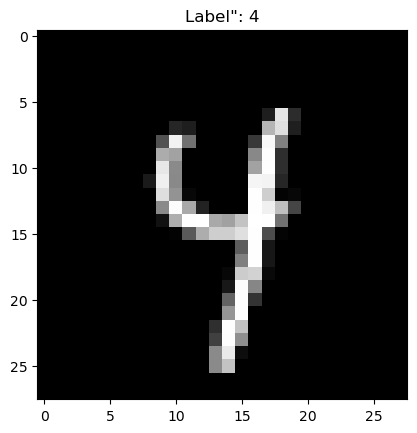

In [3]:
instance = 25
plt.imshow(np.reshape(np.array(train.iloc[instance,1:]), (-1,28)), cmap = 'gray')
plt.title('Label": %i' %train.iloc[instance, 0])
plt.show()

In [4]:
print(train.shape)
print(test.shape)

(59999, 785)
(9999, 785)


In [5]:
X_train = train.drop(columns=train.columns[0], axis = 1)
Y_train = train[train.columns[0]]

X_test = test.drop(columns=test.columns[0], axis = 1)
Y_test  = test[test.columns[0]]

In [6]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(59999, 784)
(59999,)
(9999, 784)
(9999,)


In [27]:
#scale the data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [9]:
from sklearn.decomposition import TruncatedSVD
from tqdm import tqdm

In [10]:
variance_list = []
buffer =[]
for i in tqdm(range(1, X_train.shape[1])):
    svd = TruncatedSVD(n_components=i, random_state=42)
    svd.fit(X_train)
    variance_list.append(svd.explained_variance_ratio_.sum())
    #print(svd.explained_variance_ratio_.sum())
    if(svd.explained_variance_ratio_.sum()>=0.9):
        buffer.append(i)

100%|██████████████████████████████████████████████████████████████████████████████| 783/783 [1:55:31<00:00,  8.85s/it]


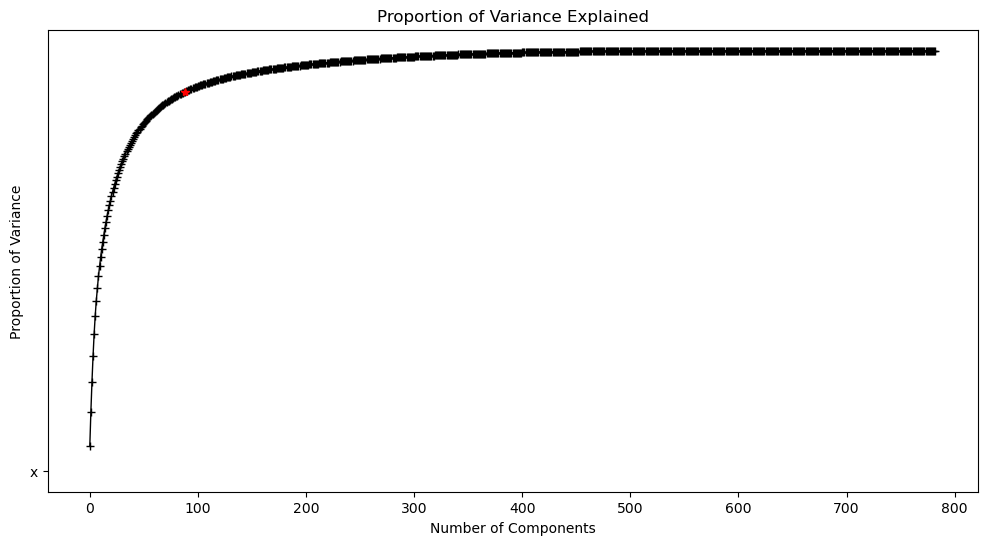

In [17]:
plt.figure(figsize=(12, 6))
plt.plot(variance_list, marker='+', color = 'black', linewidth=1)
plt.plot(buffer[0], variance_list[buffer[0]], 'r*', 'x')
plt.title("Proportion of Variance Explained")
plt.xlabel("Number of Components")
plt.ylabel("Proportion of Variance")
plt.savefig('Proportion of Variance Explained.png')
#plt.show()

In [18]:
n_components = buffer[0]
print("Selected n_component: ",n_components,". It's variance ratio: ", variance_list[n_components])

svd = TruncatedSVD(n_components)

X_train_transformed = svd.fit_transform(X_train)

X_test_transformed = svd.transform(X_test)

print(X_train_transformed.shape)

Selected n_component:  88 . It's variance ratio:  0.9023708914540174
(59999, 88)


In [19]:
#Logistic Regression on the original dataset
from sklearn.linear_model import SGDClassifier

 #creating validation for hypertuning learning rate
XX_train, XX_val, YY_train, YY_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)   

scores = []
learning_rates = []
initial_lrate = 0.01
for i in tqdm(range(10)):
    lr = initial_lrate * (1 / (1 + 0.01 * i))  #tying with different lr
    LogR =  SGDClassifier(random_state=0, alpha = lr, loss='log_loss').fit(XX_train, YY_train)
    scores.append(LogR.score(XX_val, YY_val))
    learning_rates.append(lr)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:00<00:00,  6.08s/it]


In [20]:
a = learning_rates[scores.index(max(scores))]
print("Best value of learning rate: ", a)

#now on test data
LR =  SGDClassifier(random_state=0, alpha = learning_rates[scores.index(max(scores))], loss='log_loss').fit(X_train, Y_train)
print("Accuracy of Logistic Regression on the original dataset: ", round(LR.score(X_test, Y_test)*100,4))

Best value of learning rate:  0.009174311926605503
Accuracy of Logistic Regression on the original dataset:  76.4676


In [21]:
#Logistic Regression on the reduced dataset
from sklearn.linear_model import SGDClassifier
LR =  SGDClassifier(alpha = 0.001, loss='log_loss').fit(X_train_transformed, Y_train)
print("Accuracy of Logistic Regression on the reduced dataset: ", round(LR.score(X_test_transformed, Y_test)*100,4))

Accuracy of Logistic Regression on the reduced dataset:  73.2773


In [22]:
#KNN on the original dataset
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier

strtfdKFold = StratifiedKFold(n_splits=4)
kfold = strtfdKFold.split(X_train, Y_train)

k_values = [1, 7, 18, int(np.sqrt(len(X_train)))]       #taking random k values for different folds
scores = []
for k, (t, v) in enumerate(kfold):
    neigh = KNeighborsClassifier(n_neighbors= k_values[k])
    neigh.fit(X_train[t, :], Y_train.iloc[t])
    y_pred = neigh.predict(X_train[v, :])
    scores.append(accuracy_score(Y_train.iloc[v],y_pred))

#Based on the k value that resulted the best accuracy in the validation set we will now be testing on the test set as well
neigh = KNeighborsClassifier(n_neighbors= k_values[scores.index(max(scores))])
neigh.fit(X_train, Y_train)
y_pred = neigh.predict(X_test)

In [23]:
print("Accuracy of KNN on the original dataset: ", round(accuracy_score(Y_test,y_pred)*100,4))

Accuracy of KNN on the original dataset:  67.4267


In [24]:
#KNN on the reduced dataset
neigh = KNeighborsClassifier(n_neighbors= k_values[scores.index(max(scores))])
neigh.fit(X_train_transformed, Y_train)
y_pred = neigh.predict(X_test_transformed)
print("Accuracy of KNN on the reduced dataset: ", round(accuracy_score(Y_test,y_pred)*100,4))

Accuracy of KNN on the reduced dataset:  66.3466


In [25]:
#Naive Bayes on the original dataset

from sklearn.naive_bayes import GaussianNB
X_train = X_train*255.0
X_test = X_test*255.0

svd = TruncatedSVD(n_components=500)

X_train_transformed = svd.fit_transform(X_train)

X_test_transformed = svd.transform(X_test)

gnb = GaussianNB(var_smoothing = 0.05)
y_pred = gnb.fit(X_train, Y_train).predict(X_test)
print("Accuracy of Naive Bayes on the original dataset: ", round(accuracy_score(Y_test,y_pred)*100,4))

Accuracy of Naive Bayes on the original dataset:  64.9765


In [26]:
#Naive Bayes on the reduced dataset
gnb = GaussianNB(var_smoothing = 0.05)
y_pred = gnb.fit(X_train_transformed, Y_train).predict(X_test_transformed)
print("Accuracy of Naive Bayes on the reduced dataset: ", round(accuracy_score(Y_test,y_pred)*100,4))

Accuracy of Naive Bayes on the reduced dataset:  23.3323
